# Retrieve Snow Denisties and Plot

retrieve densitities within pits and plot against ? (grain size? hardness? depth?)

## Retrieve Snow Denisties From SnowEx SQL Database


https://snowex-hackweek.github.io/website/tutorials/microstructure/microstructure-tutorial.html

In [102]:
# Modules needed to access snowexsql: SnowEx field data database
from snowexsql.db import get_db
from snowexsql.data import SiteData, PointData, LayerData, ImageData
from snowexsql.conversions import points_to_geopandas, query_to_geopandas

# Modules needed to work with data
import geoalchemy2.functions as gfunc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#note - this cell does not return any output

In [3]:
# Import the class reflecting the points table in the db
from snowexsql.data import SiteData

# Import the function to investigate a table
from snowexsql.db import get_table_attributes

# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(SiteData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))


These are the available columns in the table:
 
* air_temp
* aspect
* date
* date_accessed
* doi
* easting
* elevation
* geom
* ground_condition
* ground_roughness
* ground_vegetation
* latitude
* longitude
* metadata
* northing
* precip
* site_id
* site_name
* site_notes
* sky_cover
* slope_angle
* time
* time_created
* time_updated
* total_depth
* tree_canopy
* utm_zone
* vegetation_height
* weather_description
* wind



## clean up density data

### download density data from database

In [168]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab all the equivalent diameter profiles
q = session.query(LayerData).filter(LayerData.type == 'density')
density_df = query_to_geopandas(q, engine)

# End our database session to avoid hanging transactions
session.close()

# density_df.head() #check out the results of the query

In [169]:
# convert data formats from "object" to workable formats
density_df['depth'] = density_df['depth'].astype(float)
density_df['value'] = density_df['value'].astype(float)
density_df['latitude'] = density_df['latitude'].astype(float)

In [285]:
# filter the dataframe for the desired columns
density_filter_df = density_df[['site_id','latitude', 'longitude','depth','bottom_depth','sample_a','sample_b','sample_c','value']].copy()

In [171]:
# # check the data for a site to see what we're working with, we'll use site 1C1 as an example
# density_filter_df[density_filter_df.site_id == '1C1'] # list the values of the dataframe where the site_id is equal to 1C1

Oh no! It looks like for each density measurement, there is a unique row. This means we have redundant average densities (i.e. the value in the 'value' column) for some depths. 
Let's filter this data so that we only have one density for each depth within each pit

In [172]:
# list the unique site id values in the dataframe
site_id_unique = density_filter_df['site_id'].unique()

In [287]:
# for each of the unique site_id's, go to where the "site_id" column in the dataframe is equal to that site id. from there drop redundant depth values, and reassign the site id column to the newly filtered set of values
for site_num in range(site_id_unique.size):
    density_filter_df[density_filter_df.site_id == site_id_unique[site_num]] = density_filter_df[density_filter_df.site_id == site_id_unique[site_num]].drop_duplicates(subset='depth', keep="last")

In [301]:
# drop NaN values
density_filter_df = density_filter_df.dropna(subset=['site_id','depth','value'])

### download site data from database

In [302]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab all the equivalent diameter profiles
q = session.query(SiteData)
siteData_df = query_to_geopandas(q, engine)

# End our database session to avoid hanging transactions
session.close()

#siteData_df.head() #check out the results of the query

In [303]:
# filter for the values we want
siteData_filter_df = siteData_df[['site_id','tree_canopy']].copy()

### merge the two dataframes based on the site_id column and sort based on site_id and depth

In [483]:
# create a merged dataframe
merged_df = density_filter_df.merge(siteData_filter_df, on = 'site_id')
# rename the density column for clarity
merged_df = merged_df.rename(columns={"value": "density"})

# sort values so that we can determine top 10 and 50 cm from each pit
merged_df = merged_df.sort_values(by=['site_id', 'depth'],ascending=False)

In [484]:
# for each of the unique site_id's, go to where the "site_id" column in the dataframe is equal to that site id. from there drop redundant depth values, and reassign the site id column to the newly filtered set of values
for site_num in range(site_id_unique.size):
    merged_df[merged_df.site_id == site_id_unique[site_num]] = merged_df[merged_df.site_id == site_id_unique[site_num]].drop_duplicates(subset='depth', keep="last")

In [487]:
merged_df.density[merged_df.density < 50] = np.nan
merged_df = merged_df.dropna(subset=['site_id','depth','density'])
merged_df = merged_df.reset_index(drop=True)
#merged_df = merged_df.drop(columns=['bottom_depth','sample_a','sample_b','sample_c']) # comment out if you want to see which sites have multiple measurements

In [403]:
densityAgg_df = merged_df.groupby('site_id').agg({'density': ['mean']})
densityAgg_df = densityAgg_df.rename(columns={'density': "avg_total"})

max depth per site - 10, ma

### create new dataframes with upper 10 and 50 cm depths for each profile

### upper 50 cm

In [385]:
#create a copy of the merged dataframe 
merged_top50_df = merged_df.copy()

In [386]:
# we want the top 50 cm
for site_num in range(site_id_unique.size):
    merged_top50_df[merged_top50_df.site_id == site_id_unique[site_num]] = merged_top50_df[merged_top50_df.site_id == site_id_unique[site_num]].head(5)
    
merged_top50_df.reset_index();

In [387]:
# drop all nans
merged_top50_df = merged_top50_df.dropna(subset=['site_id','depth','density'])

In [405]:
top50_densityAgg_df = merged_top50_df.groupby('site_id').agg({'density': ['mean']})
top50_densityAgg_df = top50_densityAgg_df.rename(columns={'density': "avg_50"})
#top50_densityAgg_df = merged_df.groupby('site_id').agg({'depth': ['max']})

### upper 10 cm

In [389]:
#create a copy of the merged dataframe 
merged_top10_df = merged_df.copy()

# we want the top 50 cm
for site_num in range(site_id_unique.size):
    merged_top10_df[merged_top10_df.site_id == site_id_unique[site_num]] = merged_top10_df[merged_top10_df.site_id == site_id_unique[site_num]].head(1)
# drop all nans
merged_top10_df = merged_top10_df.dropna(subset=['site_id','depth','density'])  
merged_top10_df.reset_index();


## merge final calculations into dataframe

In [488]:
density_final_df = merged_top10_df.merge(top50_densityAgg_df, on = 'site_id')
density_final_df = density_final_df.merge(densityAgg_df, on = 'site_id')

In [489]:
density_final_df = density_final_df.rename(columns={('avg_50','mean'): "density_avg50", 'density':'density_avg10',('avg_total','mean'): "density_avgTotal"})

## Plot

#### Summary Stats (histograms)

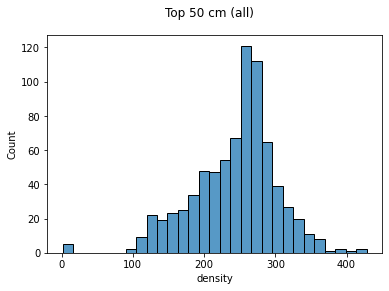

In [431]:
fig, ax = plt.subplots()
fig.suptitle('Top 50 cm (all)')
sns.histplot(data=merged_top50_df, x="density");

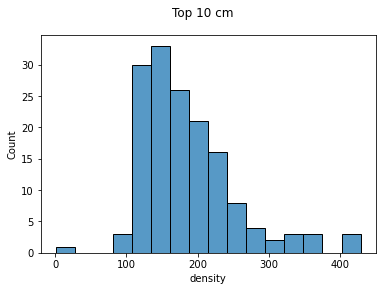

In [429]:
fig, ax = plt.subplots()
fig.suptitle('Top 10 cm')
sns.histplot(data=merged_top10_df, x="density");

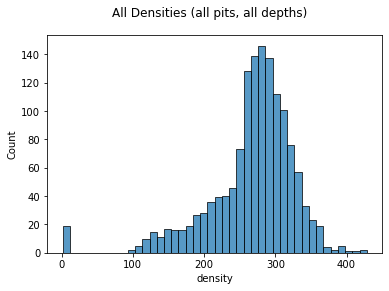

In [433]:
fig, ax = plt.subplots()
fig.suptitle('All Densities (all pits, all depths)')
sns.histplot(data=merged_df, x="density");

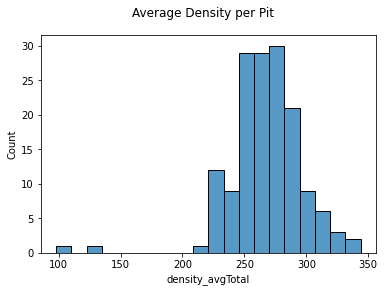

In [437]:
fig, ax = plt.subplots()
fig.suptitle('Average Density per Pit')
sns.histplot(data=merge_final, x="density_avgTotal");

In [471]:
merged_df

,site_id,latitude,longitude,depth,density,tree_canopy
0,TLSFL2A,39.036676,-108.189449,90.0,105.500000,Sparse (5-20%)
1,TLSFL2A,39.036676,-108.189449,80.0,363.500000,Sparse (5-20%)
2,TLSFL2A,39.036676,-108.189449,70.0,271.500000,Sparse (5-20%)
3,TLSFL2A,39.036676,-108.189449,60.0,333.500000,Sparse (5-20%)
4,TLSFL2A,39.036676,-108.189449,50.0,310.333333,Sparse (5-20%)
...,...,...,...,...,...,...
1433,1C1,39.064288,-108.220237,17.0,274.000000,No Trees
1434,NaN,NaN,NaN,NaN,NaN,NaN
1435,1C1,39.064179,-108.220218,13.0,216.000000,No Trees
1436,NaN,NaN,NaN,NaN,NaN,NaN


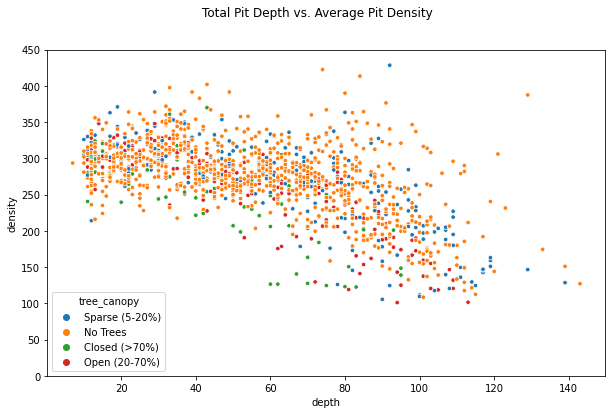

In [507]:
fig, ax = plt.subplots(1, figsize=(10, 6), sharey=True)
fig.suptitle('Total Pit Depth vs. Average Pit Density')

sns.scatterplot(ax=ax, x=merged_df.depth, y=merged_df.density,marker = '.',s = 80,hue = merged_df.tree_canopy)
ax.set(ylim=(0, 450));

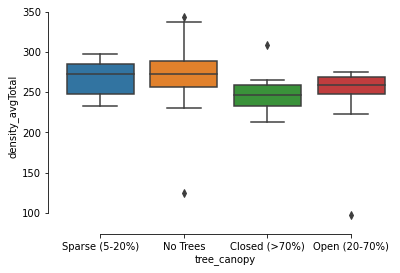

In [492]:
sns.boxplot(x="tree_canopy", y="density_avgTotal",
            data=density_final_df)
sns.despine(offset=10, trim=True)

density

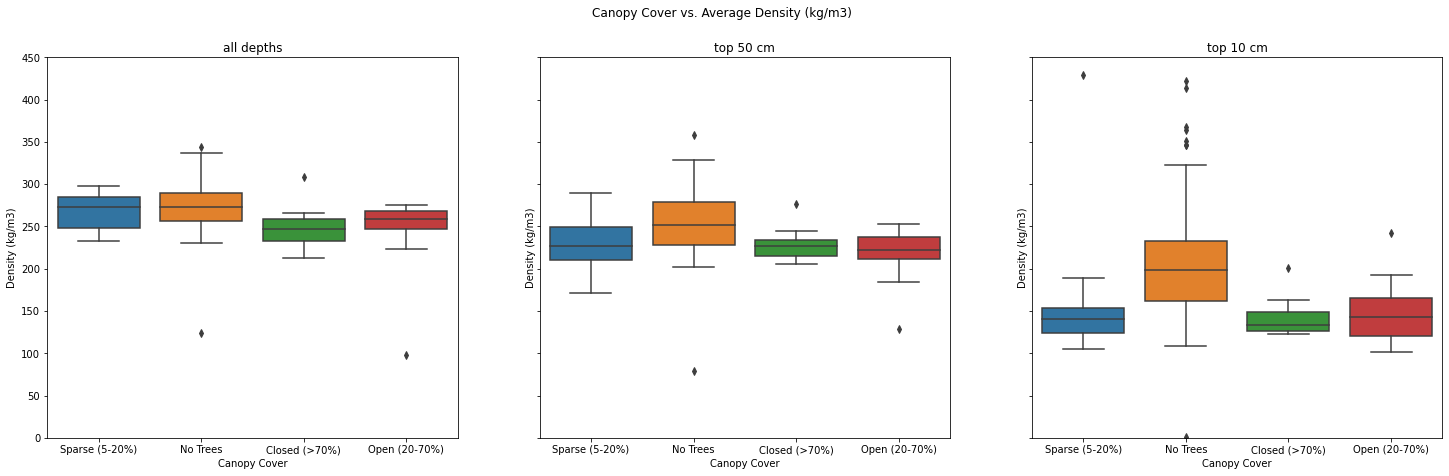

In [512]:
#createa a figure axis
fig, axes = plt.subplots(1, 3, figsize=(25, 7), sharey=True)
fig.suptitle('Canopy Cover vs. Average Density (kg/m3)')

sns.boxplot(ax=axes[0], x=density_final_df.tree_canopy, y=density_final_df.density_avgTotal)
axes[0].set_title('all depths')
axes[0].set_xlabel('Canopy Cover')
axes[0].set_ylabel('Density (kg/m3)')
axes[0].set(ylim=(0, 450));

sns.boxplot(ax=axes[1], x=density_final_df.tree_canopy, y=density_final_df.density_avg50)
axes[1].set_title('top 50 cm')
axes[1].set_xlabel('Canopy Cover')
axes[1].set_ylabel('Density (kg/m3)')
axes[1].set(ylim=(0, 450));

sns.boxplot(ax=axes[2], x=density_final_df.tree_canopy, y=density_final_df.density_avg10)
axes[2].set_title('top 10 cm')
axes[2].set_xlabel('Canopy Cover')
axes[2].set_ylabel('Density (kg/m3)');
axes[2].set(ylim=(0, 450));

#fig.savefig('/home/jovyan/snow-sinking/density_files/tree_avgDensity_fig.png',dpi = 200)

depth

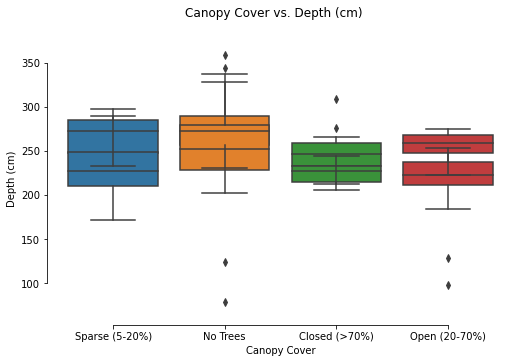

In [509]:
#createa a figure axis
fig, ax = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. Depth (cm)')
sns.boxplot(x="tree_canopy", y="density_avgTotal",
            data=density_final_df)
sns.boxplot(x="tree_canopy", y="density_avg50",
            data=density_final_df)
ax.set_xlabel('Canopy Cover')
ax.set_ylabel('Depth (cm)')
sns.despine(offset=10, trim=True)
#fig.savefig('/home/jovyan/snow-sinking/density_files/tree_depth_fig.png',dpi = 200)

In [ ]:
#createa a figure axis
fig, ax = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. Depth (cm)')
sns.boxplot(x="tree_canopy", y="depth",
            data=merged_df)
ax.set_xlabel('Canopy Cover')
ax.set_ylabel('Depth (cm)')
sns.despine(offset=10, trim=True)
#fig.savefig('/home/jovyan/snow-sinking/density_files/tree_depth_fig.png',dpi = 200)

In [ ]:
# density_groupSite_df = merged_df.groupby('site_id').agg({'value': ['mean', 'min', 'max']})
# density_groupSite_df = merged_df.groupby('site_id').agg({'depth': ['max']})